In [1]:
import os
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

In [2]:
import torch

if torch.cuda.is_available():
    print("GPU is available!")
    print(f"Using device: {torch.cuda.get_device_name(0)}")
else:
    print("No GPU. Using CPU.")

GPU is available!
Using device: NVIDIA GeForce GTX 1650 Ti


In [3]:
!pip install gdown --quiet
!gdown '1bzTrvDtnVOeL9Ft_6omSKumvU8qaO3vw'

Downloading...
From (original): https://drive.google.com/uc?id=1bzTrvDtnVOeL9Ft_6omSKumvU8qaO3vw
From (redirected): https://drive.google.com/uc?id=1bzTrvDtnVOeL9Ft_6omSKumvU8qaO3vw&confirm=t&uuid=48545c21-c4e9-494e-87f9-a5a050a3214c
To: /content/final_data_with_summarization.csv
100% 288M/288M [00:03<00:00, 90.4MB/s]


# 1. Loading the Data

In [3]:
df = pd.read_csv(r"final_data_with_summarization.csv")

In [4]:
df

,title,text,label,title_tokens,text_tokens,text_summary
0,NaN,Did they post their votes for Hillary already?,1,2,11,NaN
1,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1,30,38,NaN
2,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,25,425,NaN
3,About Time! Christian Group Sues Amazon and SP...,All we can say on this one is it s about time ...,1,18,325,NaN
4,DR BEN CARSON TARGETED BY THE IRS: “I never ha...,DR. BEN CARSON TELLS THE STORY OF WHAT HAPPENE...,1,26,19,NaN
...,...,...,...,...,...,...
72118,Russians steal research on Trump in hack of U....,WASHINGTON (Reuters) - Hackers believed to be ...,0,16,972,Hackers believed to be working for the Russian...
72119,WATCH: Giuliani Demands That Democrats Apolog...,"You know, because in fantasyland Republicans n...",1,19,724,Giuliani demands that Democrats apologize for ...
72120,Migrants Refuse To Leave Train At Refugee Camp...,Migrants Refuse To Leave Train At Refugee Camp...,0,12,593,Thousands of migrants flooded into a train sta...
72121,Trump tussle gives unpopular Mexican leader mu...,MEXICO CITY (Reuters) - Donald Trump’s combati...,0,16,730,Donald Trump's combative style has buffeted Me...


In [5]:
df["input"] = df["text_summary"].fillna(df["text"])

In [6]:
df["input"].isnull().sum()

np.int64(39)

In [7]:
X = df["title"].fillna("") + " " + df["input"].fillna("")

In [8]:
# now fake = 1
df["label"] = df["label"].map({0: 1, 1: 0})

In [9]:
Y = df["label"]

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.15, random_state=42)

In [11]:
X_train.shape, X_val.shape, X_test.shape

((49043,), (8655,), (14425,))

# 2. Tokenization

We use the [sentence-transformers/all-MiniLM-L6-v2](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2) embedding model from huggingface.

This embedding model is relatively lightweight, one of the most popular ones, and converts an input text (max 512 tokens) into a 384 dimensional dense vector embedding.


The produced embedding can be used for checking sentence similarity, clustering, information retrieval, or text classification by passing in the embeddings as input features.

In [12]:
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModel

In [13]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

In [14]:
model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

In [15]:
model.device

device(type='cuda', index=0)

# 3. Generating Embeddings

In [16]:
X_train = X_train.values.tolist()
X_val = X_val.values.tolist()
X_test = X_test.values.tolist()

Y_train = Y_train.values.tolist()
Y_val = Y_val.values.tolist()
Y_test = Y_test.values.tolist()

In [17]:
len(X_train), len(X_val), len(X_test)

(49043, 8655, 14425)

In [18]:
from tqdm import tqdm

In [19]:
def batch_encode(text_list, model, batch_size=2048*3):
    embeddings = []
    for i in tqdm(range(0, len(text_list), batch_size)):
        batch = text_list[i:i+batch_size]
        batch_emb = model.encode(batch)
        embeddings.extend(batch_emb)
    return embeddings

In [20]:
X_val_embeddings = batch_encode(X_val, model)

100%|██████████| 2/2 [00:39<00:00, 19.72s/it]


In [21]:
X_train_embeddings = batch_encode(X_train, model)

100%|██████████| 8/8 [02:31<00:00, 18.96s/it]


In [22]:
X_test_embeddings = batch_encode(X_test, model)

100%|██████████| 3/3 [00:40<00:00, 13.52s/it]


# 4. Model Training, Optimization and Evaluation

## 4.1 Custom Helper Functions

In [23]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import ParameterSampler
from tqdm import tqdm
import copy

In [24]:
def randomized_search(model_class, param_distributions, X_train, y_train, X_val, y_val, n_iter=10, random_state=42):
    """
    Custom randomized search for hyperparameter tuning.
    """

    np.random.seed(random_state)
    param_list = list(ParameterSampler(param_distributions, n_iter=n_iter, random_state=random_state))
    best_score = -np.inf
    best_model = None
    all_results = []

    for i, params in enumerate(tqdm(param_list)):
        try:
            model = model_class(**params)
            model.fit(X_train, y_train)
            preds = model.predict(X_val)

            score = accuracy_score(y_val, preds)
            all_results.append((params, score))

            if score > best_score:
                best_score = score
                best_model = copy.deepcopy(model) # keeping track of the best perfomring model
        except Exception as e:
            print(f"Error with params {params}: {e}")
            continue

    print(f"\nBest: {best_score:.4f} with params: {all_results[np.argmax([s for _, s in all_results])][0]}")
    return best_model, best_score, all_results


In [25]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
def perform_deep_test_analysis(y_test, test_preds: np.array, test_preds_proba: np.array, model_name: str) -> None:
    """"
    This function takes in a model object and model name, and performs a deep analysis on the model's performance on the test set.
    It prints classification report, confusion matrix, ROC AUC score and plots the ROC curve.
    """
    cm = confusion_matrix(y_test, test_preds)

    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    print("\n")
    print("FOR TESTING SET: ")
    print(classification_report(y_test, test_preds))
    print("\n")

    print(f"ROC AUC Score: {roc_auc_score(y_test, test_preds_proba):.2%}")
    print("\n")

    fpr, tpr, _ = roc_curve(y_test, test_preds_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic Curve for {model_name}')
    plt.legend(loc="lower right")
    plt.show()

In [27]:
import pickle

In [28]:
def export_model(model, model_name):
  with open(f"{model_name}.pkl", "wb") as f:
    pickle.dump(model, f)

  print(f"Model {model_name} has been exported!!!")

# 4.2 Logistic Regression

In [29]:
from sklearn.linear_model import LogisticRegression

In [30]:
param_for_logistic_regression = {
    'C': np.logspace(-4, 1, 20),
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [1000],
    "random_state": [42]
}

logisticRegression_Model, best_score, search_results = randomized_search(
    LogisticRegression,
    param_distributions=param_for_logistic_regression,
    X_train=X_train_embeddings,
    y_train=Y_train,
    X_val=X_val_embeddings,
    y_val=Y_val,
    n_iter=10,
)


100%|██████████| 10/10 [00:30<00:00,  3.05s/it]


Best: 0.8358 with params: {'solver': 'liblinear', 'random_state': 42, 'penalty': 'l2', 'max_iter': 1000, 'C': np.float64(2.9763514416313193)}


In [31]:
logisticRegression_Model

LogisticRegression(C=np.float64(2.9763514416313193), max_iter=1000,
                   random_state=42, solver='liblinear')

In [32]:
export_model(logisticRegression_Model, "logisticRegression_Model")

Model logisticRegression_Model has been exported!!!


In [33]:
train_preds_logReg = logisticRegression_Model.predict(X_train_embeddings)
val_preds_logReg = logisticRegression_Model.predict(X_val_embeddings)
test_preds_logReg = logisticRegression_Model.predict(X_test_embeddings)
test_preds_proba_logReg = logisticRegression_Model.predict_proba(X_test_embeddings)[:, 1]

In [34]:
print("Training performance for Logistic Regression")
print(classification_report(Y_train, train_preds_logReg))

Training performance for Logistic Regression
              precision    recall  f1-score   support

           0       0.85      0.84      0.85     25190
           1       0.84      0.84      0.84     23853

    accuracy                           0.84     49043
   macro avg       0.84      0.84      0.84     49043
weighted avg       0.84      0.84      0.84     49043



In [35]:
print("Val performance for Logistic Regression")
print(classification_report(Y_val, val_preds_logReg))

Val performance for Logistic Regression
              precision    recall  f1-score   support

           0       0.85      0.84      0.84      4558
           1       0.82      0.84      0.83      4097

    accuracy                           0.84      8655
   macro avg       0.84      0.84      0.84      8655
weighted avg       0.84      0.84      0.84      8655



In [36]:
print("Test performance for Logistic Regression")
print(classification_report(Y_test, test_preds_logReg))

Test performance for Logistic Regression
              precision    recall  f1-score   support

           0       0.85      0.84      0.84      7347
           1       0.83      0.84      0.84      7078

    accuracy                           0.84     14425
   macro avg       0.84      0.84      0.84     14425
weighted avg       0.84      0.84      0.84     14425



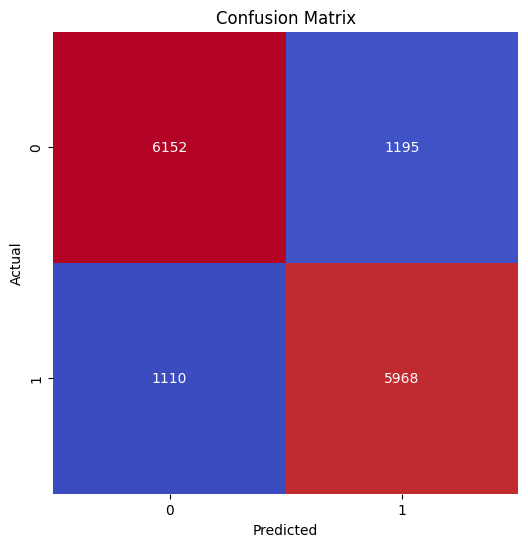



FOR TESTING SET: 
              precision    recall  f1-score   support

           0       0.85      0.84      0.84      7347
           1       0.83      0.84      0.84      7078

    accuracy                           0.84     14425
   macro avg       0.84      0.84      0.84     14425
weighted avg       0.84      0.84      0.84     14425



ROC AUC Score: 91.91%




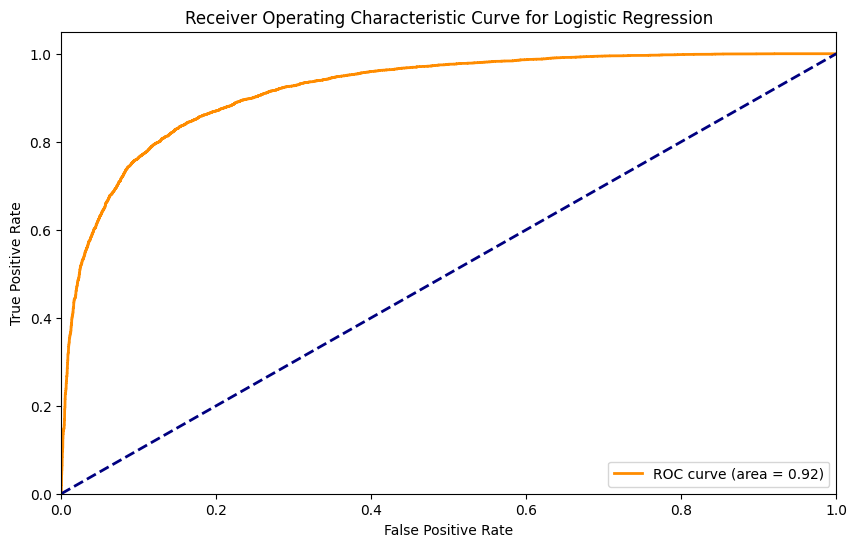

In [37]:
perform_deep_test_analysis(Y_test, test_preds_logReg, test_preds_proba_logReg, "Logistic Regression")

Logistic regression performs fairly well with accuracy and F1 scores of 0.84 on test set. Furthermore, the performance accross all 3 sets (train/val/test) is fairly similar, indicating that the model has pretty good generalization on detecting fake news on unseen data. This gives us some idea that we should probably increase complexity of this model to see if we can get more accuracy.

## 4.2 XGBoost

In [38]:
from xgboost import XGBClassifier

param_XGBoost = {
    "n_estimators": [100, 200, 300, 500, 1000],
    "max_depth": [3, 4, 5, 6],
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
    "subsample": [0.6, 0.7, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.6, 0.7, 0.8, 0.9, 1.0],
    "gamma": [0, 0.1, 0.3, 0.5, 1],
    "reg_alpha": [0, 0.01, 0.1, 1],
    "reg_lambda": [0.1, 0.5, 1, 5],
    "min_child_weight": [1, 3, 5, 7],
    "tree_method": ["gpu_hist"],
    "predictor": ["gpu_predictor"],
    "verbosity": [0],
    "random_state": [42],
    "early_stopping": [30]
}

In [48]:
XGBoost_Model, _, _ = randomized_search(
    XGBClassifier,
    param_distributions=param_XGBoost,
    X_train=X_train_embeddings,
    y_train=Y_train,
    X_val=X_val_embeddings,
    y_val=Y_val,
    n_iter=10,
)

100%|██████████| 10/10 [01:30<00:00,  9.07s/it]


Best: 0.8818 with params: {'verbosity': 0, 'tree_method': 'gpu_hist', 'subsample': 0.6, 'reg_lambda': 5, 'reg_alpha': 0.01, 'random_state': 42, 'predictor': 'gpu_predictor', 'n_estimators': 1000, 'min_child_weight': 3, 'max_depth': 6, 'learning_rate': 0.3, 'gamma': 0, 'early_stopping': 30, 'colsample_bytree': 1.0}


In [49]:
export_model(XGBoost_Model, "XGBoost_Model")

Model XGBoost_Model has been exported!!!


In [50]:
# with open('XGBoost_Model.pkl', 'rb') as file:
#     XGBoost_Model = pickle.load(file)

In [51]:
!pip show xgboost

Name: xgboost
Version: 2.1.4
Summary: XGBoost Python Package
Home-page: 
Author: 
Author-email: Hyunsu Cho <chohyu01@cs.washington.edu>, Jiaming Yuan <jm.yuan@outlook.com>
License: Apache-2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: numpy, nvidia-nccl-cu12, scipy
Required-by: 


In [52]:
train_preds_XGBOOST = XGBoost_Model.predict(X_train_embeddings)
val_preds_XGBOOST = XGBoost_Model.predict(X_val_embeddings)
test_preds_XGBOOST = XGBoost_Model.predict(X_test_embeddings)
test_preds_proba_XGBOOST = XGBoost_Model.predict_proba(X_test_embeddings)[:, 1]

In [53]:
print("XGBoost Train")
print(classification_report(Y_train, train_preds_XGBOOST))

XGBoost Train
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     25190
           1       1.00      1.00      1.00     23853

    accuracy                           1.00     49043
   macro avg       1.00      1.00      1.00     49043
weighted avg       1.00      1.00      1.00     49043



In [54]:
print("XGBoost Val")
print(classification_report(Y_val, val_preds_XGBOOST))

XGBoost Val
              precision    recall  f1-score   support

           0       0.89      0.89      0.89      4558
           1       0.87      0.88      0.88      4097

    accuracy                           0.88      8655
   macro avg       0.88      0.88      0.88      8655
weighted avg       0.88      0.88      0.88      8655



In [55]:
print("XGBoost Test")
print(classification_report(Y_test, test_preds_XGBOOST))

XGBoost Test
              precision    recall  f1-score   support

           0       0.88      0.89      0.88      7347
           1       0.88      0.87      0.88      7078

    accuracy                           0.88     14425
   macro avg       0.88      0.88      0.88     14425
weighted avg       0.88      0.88      0.88     14425



With XGBoost, we get slightly better results. We will now experiment with CNN and with a multi-layered perceptron on the embeddings and see if we get any better results.

In [79]:
test_preds_proba_XGBOOST

array([8.8344994e-09, 5.7304226e-02, 9.9921203e-01, ..., 8.9004017e-02,
       9.9240404e-01, 9.9995518e-01], dtype=float32)

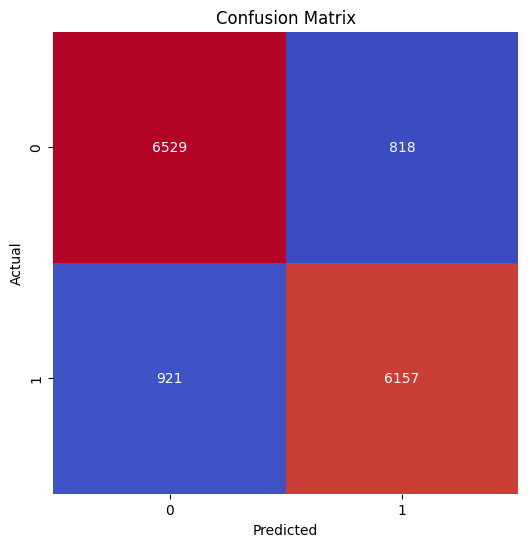



FOR TESTING SET: 
              precision    recall  f1-score   support

           0       0.88      0.89      0.88      7347
           1       0.88      0.87      0.88      7078

    accuracy                           0.88     14425
   macro avg       0.88      0.88      0.88     14425
weighted avg       0.88      0.88      0.88     14425



ROC AUC Score: 95.27%




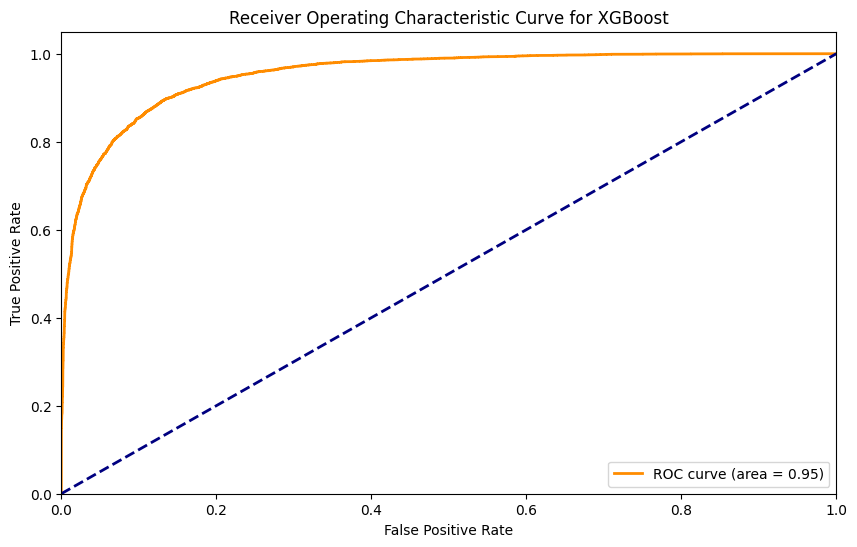

In [57]:
perform_deep_test_analysis(Y_test, test_preds_XGBOOST, test_preds_proba_XGBOOST, "XGBoost")

## 4.3 1-d CNN

In [58]:
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

In [ ]:
class EmbeddingDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(np.stack(X), dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.long)
    def __len__(self):
        return len(self.Y)
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [60]:
len(X_train_embeddings[0])

384

In [61]:
class VanillaCNN_1d(nn.Module):
    def __init__(self, input_dim, num_classes=2):
        super(VanillaCNN_1d, self).__init__()

        self.conv1 = nn.Conv1d(1, 3, kernel_size=7, padding=3)
        self.bn1 = nn.BatchNorm1d(3)
        self.pool1 = nn.AvgPool1d(2)  # 384 -> 192

        self.conv2 = nn.Conv1d(3, 6, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(6)
        self.pool2 = nn.AvgPool1d(2)  # 192 -> 96

        self.conv3 = nn.Conv1d(6, 8, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(8)
        self.pool3 = nn.AvgPool1d(2)  # 96 -> 48

        self.relu = nn.LeakyReLU()
        self.dropout = nn.Dropout(0.001)

        # after all pooling layers, we get 8 channels * 48 pixels
        self.fc = nn.Linear(8 * 48, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)  # (Batch, 1, 384)
        x = self.pool1(self.relu(self.bn1(self.conv1(x))))  # (B, 3, 192)
        x = self.pool2(self.relu(self.bn2(self.conv2(x))))  # (B, 6, 96)
        x = self.pool3(self.relu(self.bn3(self.conv3(x))))  # (B, 8, 48)
        x = x.view(x.size(0), -1)  # (B, 8 * 48)
        x = self.dropout(x)
        x = self.fc(x)            # (B, 2)
        return x

In [62]:
batch_size = 1024
train_ds = EmbeddingDataset(X_train_embeddings, Y_train)
val_ds = EmbeddingDataset(X_val_embeddings, Y_val)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_ds, batch_size=batch_size)
test_ds = EmbeddingDataset(X_test_embeddings, Y_test)
test_loader = DataLoader(test_ds, batch_size=batch_size)

In [63]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
input_dim = len(X_train_embeddings[0])
num_classes = 2
cnn = VanillaCNN_1d(input_dim, num_classes).to(device)

cuda


<b> Lets verify forward pass actually works or not

In [64]:
# Create a random input sample with 384 features
single_input = torch.randn(384)
single_input = single_input.unsqueeze(0).to(device)
output = cnn(single_input)
output.shape

torch.Size([1, 2])

Perfect! Our model has proper output shape, given input of [batch, elements], we get [batch, predicted values for each class]. We can use BCELoss with sigmoid and set num_class to 1 as well but Cross entropy loss requires unchanged outputs (without softmax as it, by default, applies softmax internally).

In [65]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=0.001, weight_decay=0.001) # medium big learning rate and some additional regulariztaion
num_epochs = 1000
early_stopping_patience = 30

In [66]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, early_stopping_patience):
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    best_val_acc = 0.0
    epochs_no_improve = 0
    best_model_wts = model.state_dict()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0
        running_total = 0

        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * xb.size(0)
            preds = out.argmax(dim=1)
            running_corrects += (preds == yb).sum().item()
            running_total += yb.size(0)

        epoch_train_loss = running_loss / running_total
        epoch_train_acc = running_corrects / running_total
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc)

        model.eval()
        val_running_loss = 0.0
        val_running_corrects = 0
        val_running_total = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                out = model(xb)
                loss = criterion(out, yb)

                val_running_loss += loss.item() * xb.size(0)
                preds = out.argmax(dim=1)
                val_running_corrects += (preds == yb).sum().item()
                val_running_total += yb.size(0)

        epoch_val_loss = val_running_loss / val_running_total
        epoch_val_acc = val_running_corrects / val_running_total
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)

        print(f"Epoch {epoch+1}: "
              f"Train Loss={epoch_train_loss:.4f}, Train Acc={epoch_train_acc:.4f}, "
              f"Val Loss={epoch_val_loss:.4f}, Val Acc={epoch_val_acc:.4f}")

        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            epochs_no_improve = 0
            best_model_wts = model.state_dict()
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= early_stopping_patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    return best_model_wts, model, train_losses, train_accuracies, val_losses, val_accuracies

In [67]:
%%time

best_model_wts, CNN_1d_Best, train_losses, train_accuracies, val_losses, val_accuracies = train_model(cnn,
                                                                                                      train_loader,
                                                                                                      val_loader,
                                                                                                      criterion,
                                                                                                      optimizer,
                                                                                                      num_epochs,
                                                                                                      early_stopping_patience)

Epoch 1: Train Loss=0.6094, Train Acc=0.6728, Val Loss=0.6367, Val Acc=0.6906
Epoch 2: Train Loss=0.5443, Train Acc=0.7273, Val Loss=0.5536, Val Acc=0.7204
Epoch 3: Train Loss=0.5218, Train Acc=0.7425, Val Loss=0.5368, Val Acc=0.7295
Epoch 4: Train Loss=0.5060, Train Acc=0.7507, Val Loss=0.5236, Val Acc=0.7402
Epoch 5: Train Loss=0.4935, Train Acc=0.7601, Val Loss=0.5132, Val Acc=0.7500
Epoch 6: Train Loss=0.4839, Train Acc=0.7661, Val Loss=0.5047, Val Acc=0.7559
Epoch 7: Train Loss=0.4767, Train Acc=0.7708, Val Loss=0.4975, Val Acc=0.7593
Epoch 8: Train Loss=0.4709, Train Acc=0.7739, Val Loss=0.4905, Val Acc=0.7656
Epoch 9: Train Loss=0.4662, Train Acc=0.7779, Val Loss=0.4853, Val Acc=0.7678
Epoch 10: Train Loss=0.4620, Train Acc=0.7807, Val Loss=0.4808, Val Acc=0.7708
Epoch 11: Train Loss=0.4583, Train Acc=0.7835, Val Loss=0.4774, Val Acc=0.7739
Epoch 12: Train Loss=0.4551, Train Acc=0.7858, Val Loss=0.4737, Val Acc=0.7713
Epoch 13: Train Loss=0.4519, Train Acc=0.7880, Val Loss=0.470

In [68]:
torch.save(best_model_wts, '1d_CNN_Best.pth')

In [69]:
CNN_1d_Best.load_state_dict(torch.load('1d_CNN_Best.pth'))

<All keys matched successfully>

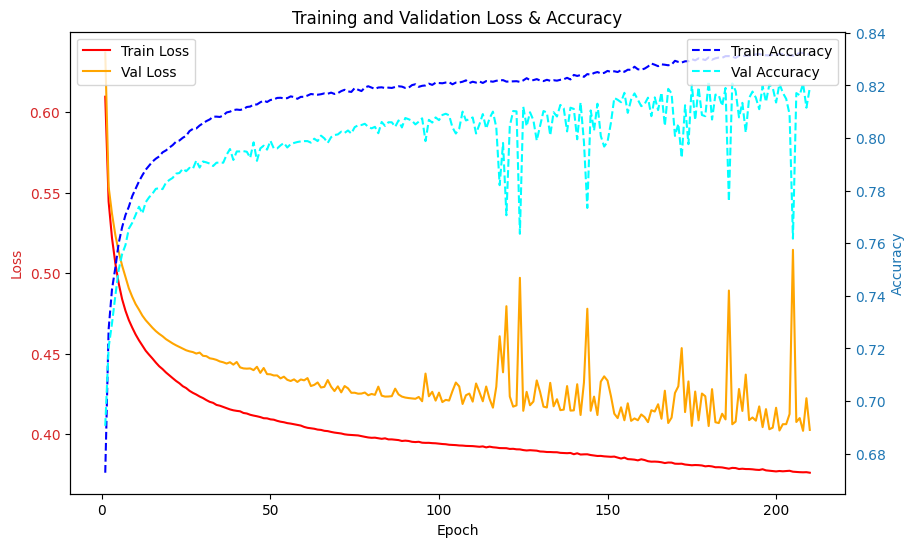

In [70]:
epochs = list(range(1, len(train_losses) + 1))

fig, ax1 = plt.subplots(figsize=(10, 6))
color_loss = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color_loss)
ax1.plot(epochs, train_losses, label='Train Loss', color='red', linestyle='-')
ax1.plot(epochs, val_losses, label='Val Loss', color='orange', linestyle='-')
ax1.tick_params(axis='y', labelcolor=color_loss)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
color_acc = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color_acc)
ax2.plot(epochs, train_accuracies, label='Train Accuracy', color='blue', linestyle='--')
ax2.plot(epochs, val_accuracies, label='Val Accuracy', color='cyan', linestyle='--')
ax2.tick_params(axis='y', labelcolor=color_acc)
ax2.legend(loc='upper right')

plt.title('Training and Validation Loss & Accuracy')
plt.show()

In [71]:
def make_predictions_using_NN(model, data_loader):
    model.eval()
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for xb, labels in data_loader:
            xb = xb.to(device)
            logits = model(xb)

            probs = torch.softmax(logits, dim=1)
            preds = torch.argmax(logits, dim=1)
            all_preds.append(preds.cpu())
            all_probs.append(probs.cpu())

    all_preds = torch.cat(all_preds)
    all_probs = torch.cat(all_probs)
    return all_preds, all_probs

In [72]:
train_preds_1dCNN, train_probs_1dCNN = make_predictions_using_NN(CNN_1d_Best, train_loader)
val_preds_1dCNN, val_probs_1dCNN = make_predictions_using_NN(CNN_1d_Best, val_loader)
test_preds_1dCNN, test_probs_1dCNN = make_predictions_using_NN(CNN_1d_Best, test_loader)

In [73]:
print("Training performance for 1-d CNN")
print(classification_report(Y_train, train_preds_1dCNN))

Training performance for 1-d CNN
              precision    recall  f1-score   support

           0       0.82      0.86      0.84     25190
           1       0.84      0.80      0.82     23853

    accuracy                           0.83     49043
   macro avg       0.83      0.83      0.83     49043
weighted avg       0.83      0.83      0.83     49043



In [74]:
print("Val performance for 1-d CNN")
print(classification_report(Y_val, val_preds_1dCNN))

Val performance for 1-d CNN
              precision    recall  f1-score   support

           0       0.82      0.84      0.83      4558
           1       0.82      0.79      0.81      4097

    accuracy                           0.82      8655
   macro avg       0.82      0.82      0.82      8655
weighted avg       0.82      0.82      0.82      8655



In [75]:
print("Test performance for 1-d CNN")
print(classification_report(Y_test, test_preds_1dCNN))

Test performance for 1-d CNN
              precision    recall  f1-score   support

           0       0.81      0.85      0.83      7347
           1       0.84      0.79      0.81      7078

    accuracy                           0.82     14425
   macro avg       0.82      0.82      0.82     14425
weighted avg       0.82      0.82      0.82     14425



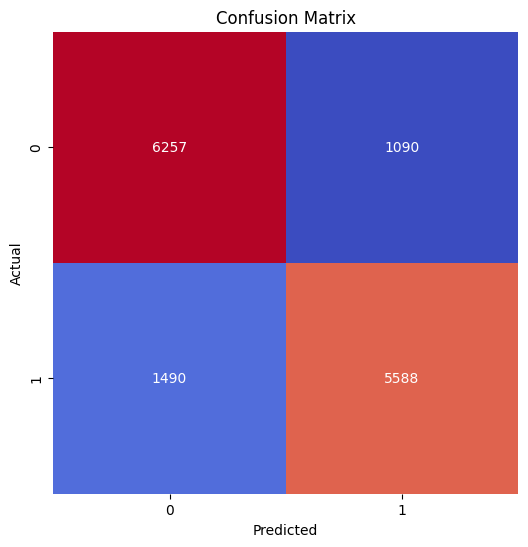



FOR TESTING SET: 
              precision    recall  f1-score   support

           0       0.81      0.85      0.83      7347
           1       0.84      0.79      0.81      7078

    accuracy                           0.82     14425
   macro avg       0.82      0.82      0.82     14425
weighted avg       0.82      0.82      0.82     14425



ROC AUC Score: 90.17%




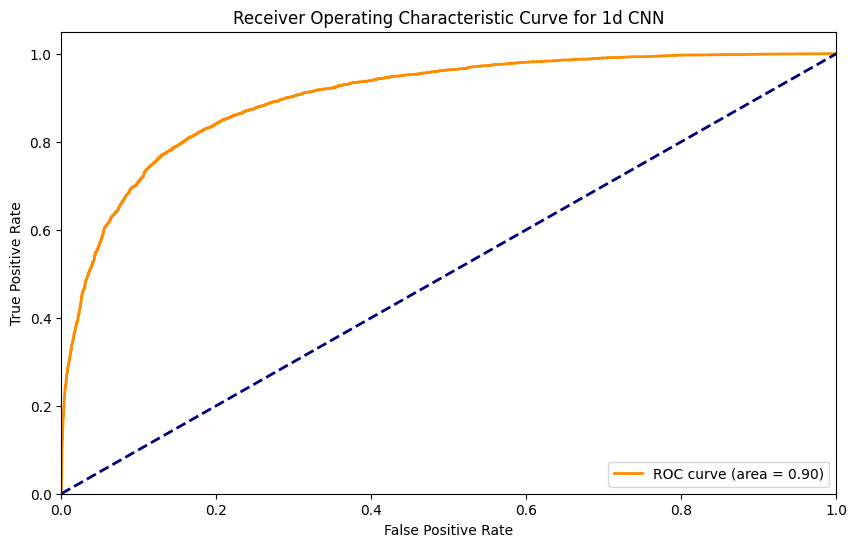

In [80]:
perform_deep_test_analysis(Y_test, test_preds_1dCNN, test_probs_1dCNN[:, 1], "1d CNN")

Not bad at all given that we used a 1-d CNN (with batchnorm, average pooling, LeakyRelu and Dropout). Lets see if reshaping the input embeddings into 2d (to mimic a greyscale image) and retrying a 2d CNN works better or not.

## 4.4 2-d CNN

In [81]:
input_dim, 16*24

(384, 384)

Lets reshape input embeddings to 16*24 (total 384) so that it will mimic a greyscale image.

In [82]:
import torch
import torch.nn as nn

class VanillaCNN_2d(nn.Module):
    def __init__(self, num_classes=2):
        super(VanillaCNN_2d, self).__init__()

        self.conv1 = nn.Conv2d(1, 3, kernel_size=(3,3), padding=1) # input: 1 channel * 16 height * 24 height
        self.bn1 = nn.BatchNorm2d(3)
        self.pool1 = nn.AvgPool2d(2)  # 1 * 16 * 24 -> 3 * 8 * 12

        self.conv2 = nn.Conv2d(3, 6, kernel_size=(3,3), padding=1)
        self.bn2 = nn.BatchNorm2d(6)
        self.pool2 = nn.AvgPool2d(2)  # 3 * 8  * 12 -> 6 * 4 * 6

        self.conv3 = nn.Conv2d(6, 8, kernel_size=(3,3), padding=1)
        self.bn3 = nn.BatchNorm2d(8)
        self.pool3 = nn.AvgPool2d(2)  # 6 * 4 * 6 -> 8 * 2 * 3

        self.relu = nn.LeakyReLU()
        self.dropout = nn.Dropout(0.001)

        # flattening the 3d array (8 channels * 2 * 3 = 48 input neurons in fully connected layer)
        self.fc = nn.Linear(8 * 2 * 3, num_classes)

    def forward(self, x):
        # Reshape 384 -> 1x16x24 (channel, height, width); this way, it mimics a greyscale image
        x = x.view(-1, 1, 16, 24)
        x = self.pool1(self.relu(self.bn1(self.conv1(x))))  # (B, 3, 8, 12)
        x = self.pool2(self.relu(self.bn2(self.conv2(x))))  # (B, 6, 4, 6)
        x = self.pool3(self.relu(self.bn3(self.conv3(x))))  # (B, 8, 2, 3)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [83]:
cnn_2d = VanillaCNN_2d(num_classes).to(device)

# Create a random input sample with 384 features
single_input = torch.randn(384)
single_input = single_input.unsqueeze(0).to(device)
output = cnn_2d(single_input)
output.shape

torch.Size([1, 2])

Perfect! The 2d cnn's forward pass is also proper. Lets train this model.

In [84]:
%%time

optimizer = optim.Adam(cnn_2d.parameters(), lr=0.001, weight_decay=0.001)

# every single parameter is the same as 1-d cnn model. the only difference is the model
best_model_wts_2d, CNN_2d_Best, train_losses, train_accuracies, val_losses, val_accuracies = train_model(cnn_2d,
                                                                                                      train_loader,
                                                                                                      val_loader,
                                                                                                      criterion,
                                                                                                      optimizer,
                                                                                                      num_epochs,
                                                                                                      early_stopping_patience)

Epoch 1: Train Loss=0.6585, Train Acc=0.6120, Val Loss=0.6814, Val Acc=0.5765
Epoch 2: Train Loss=0.6049, Train Acc=0.6820, Val Loss=0.6112, Val Acc=0.6642
Epoch 3: Train Loss=0.5635, Train Acc=0.7150, Val Loss=0.5720, Val Acc=0.6995
Epoch 4: Train Loss=0.5400, Train Acc=0.7290, Val Loss=0.5515, Val Acc=0.7163
Epoch 5: Train Loss=0.5249, Train Acc=0.7401, Val Loss=0.5371, Val Acc=0.7281
Epoch 6: Train Loss=0.5139, Train Acc=0.7467, Val Loss=0.5272, Val Acc=0.7330
Epoch 7: Train Loss=0.5048, Train Acc=0.7518, Val Loss=0.5201, Val Acc=0.7381
Epoch 8: Train Loss=0.4975, Train Acc=0.7571, Val Loss=0.5145, Val Acc=0.7407
Epoch 9: Train Loss=0.4917, Train Acc=0.7603, Val Loss=0.5097, Val Acc=0.7459
Epoch 10: Train Loss=0.4869, Train Acc=0.7639, Val Loss=0.5057, Val Acc=0.7490
Epoch 11: Train Loss=0.4828, Train Acc=0.7671, Val Loss=0.5020, Val Acc=0.7534
Epoch 12: Train Loss=0.4796, Train Acc=0.7692, Val Loss=0.4983, Val Acc=0.7560
Epoch 13: Train Loss=0.4764, Train Acc=0.7712, Val Loss=0.494

Interesting. Reshaping into a 2d matrix seems to work actually.

In [85]:
torch.save(best_model_wts_2d, '2d_CNN_Best.pth')

In [86]:
cnn_2d.load_state_dict(torch.load('2d_CNN_Best.pth'))

<All keys matched successfully>

In [88]:
train_preds_2dCNN, train_probs_2dCNN = make_predictions_using_NN(cnn_2d, train_loader)
val_preds_2dCNN, val_probs_2dCNN = make_predictions_using_NN(cnn_2d, val_loader)
test_preds_2dCNN, test_probs_2dCNN = make_predictions_using_NN(cnn_2d, test_loader)

In [89]:
print("Training performance for 2-d CNN")
print(classification_report(Y_train, train_preds_2dCNN))

Training performance for 2-d CNN
              precision    recall  f1-score   support

           0       0.85      0.75      0.80     25190
           1       0.77      0.86      0.81     23853

    accuracy                           0.80     49043
   macro avg       0.81      0.80      0.80     49043
weighted avg       0.81      0.80      0.80     49043



In [90]:
print("Val performance for 2-d CNN")
print(classification_report(Y_val, val_preds_2dCNN))

Val performance for 2-d CNN
              precision    recall  f1-score   support

           0       0.84      0.74      0.78      4558
           1       0.74      0.84      0.79      4097

    accuracy                           0.79      8655
   macro avg       0.79      0.79      0.79      8655
weighted avg       0.79      0.79      0.79      8655



In [91]:
print("Test performance for 2-d CNN")
print(classification_report(Y_test, test_preds_2dCNN))

Test performance for 2-d CNN
              precision    recall  f1-score   support

           0       0.83      0.74      0.79      7347
           1       0.76      0.85      0.80      7078

    accuracy                           0.79     14425
   macro avg       0.80      0.79      0.79     14425
weighted avg       0.80      0.79      0.79     14425



Well. Not bad all all. The key will be to tune the convolution layers and shape of the matrix.

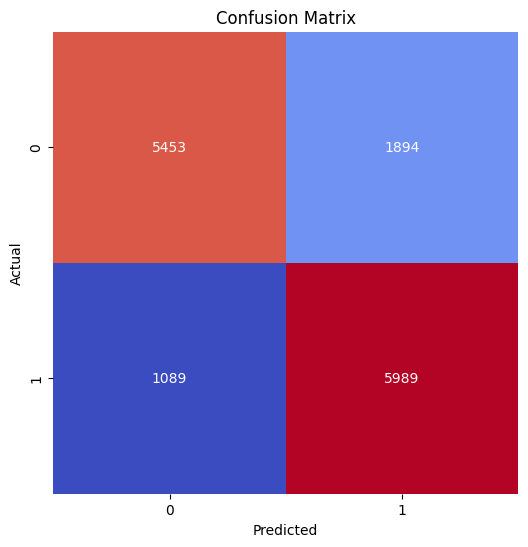



FOR TESTING SET: 
              precision    recall  f1-score   support

           0       0.83      0.74      0.79      7347
           1       0.76      0.85      0.80      7078

    accuracy                           0.79     14425
   macro avg       0.80      0.79      0.79     14425
weighted avg       0.80      0.79      0.79     14425



ROC AUC Score: 88.21%




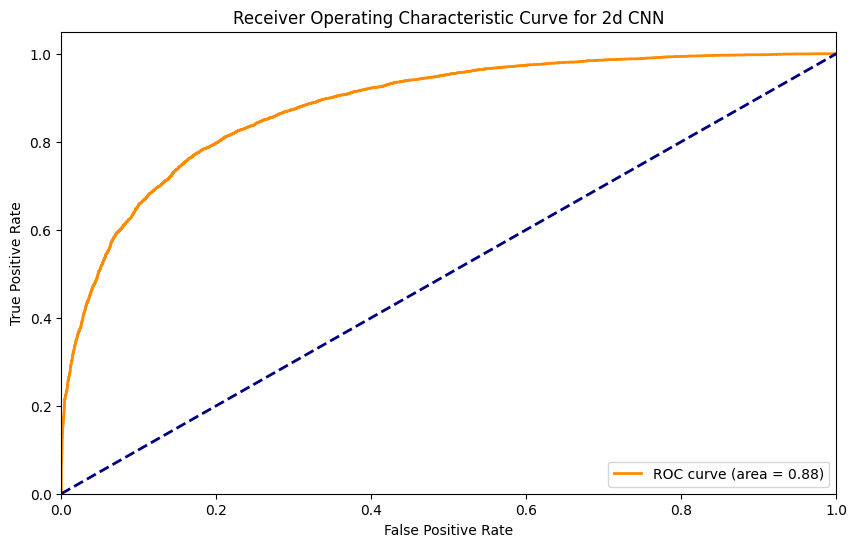

In [92]:
perform_deep_test_analysis(Y_test, test_preds_2dCNN, test_probs_2dCNN[:, 1], "2d CNN")

## 4.5 Multi-Layered Perceptron

In [93]:
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.relu = nn.LeakyReLU()
        self.fc2 = nn.Linear(128, num_classes)
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

mlp = SimpleMLP(input_dim, num_classes).to(device)

In [94]:
%%time

optimizer = optim.Adam(mlp.parameters(), lr=0.001, weight_decay=0.001)

# every single parameter is the same as 1-d cnn model. the only difference is the model
best_model_wts_mlp, mlp_Best, train_losses, train_accuracies, val_losses, val_accuracies = train_model(mlp,
                                                                                                      train_loader,
                                                                                                      val_loader,
                                                                                                      criterion,
                                                                                                      optimizer,
                                                                                                      num_epochs,
                                                                                                      early_stopping_patience)

Epoch 1: Train Loss=0.5919, Train Acc=0.7112, Val Loss=0.5056, Val Acc=0.7604
Epoch 2: Train Loss=0.4547, Train Acc=0.7921, Val Loss=0.4409, Val Acc=0.7986
Epoch 3: Train Loss=0.4164, Train Acc=0.8147, Val Loss=0.4204, Val Acc=0.8070
Epoch 4: Train Loss=0.4008, Train Acc=0.8220, Val Loss=0.4095, Val Acc=0.8139
Epoch 5: Train Loss=0.3912, Train Acc=0.8267, Val Loss=0.4017, Val Acc=0.8181
Epoch 6: Train Loss=0.3841, Train Acc=0.8304, Val Loss=0.3953, Val Acc=0.8222
Epoch 7: Train Loss=0.3783, Train Acc=0.8338, Val Loss=0.3899, Val Acc=0.8252
Epoch 8: Train Loss=0.3734, Train Acc=0.8374, Val Loss=0.3853, Val Acc=0.8287
Epoch 9: Train Loss=0.3691, Train Acc=0.8399, Val Loss=0.3812, Val Acc=0.8308
Epoch 10: Train Loss=0.3652, Train Acc=0.8421, Val Loss=0.3776, Val Acc=0.8326
Epoch 11: Train Loss=0.3617, Train Acc=0.8440, Val Loss=0.3744, Val Acc=0.8343
Epoch 12: Train Loss=0.3585, Train Acc=0.8456, Val Loss=0.3716, Val Acc=0.8358
Epoch 13: Train Loss=0.3556, Train Acc=0.8465, Val Loss=0.369

In [95]:
torch.save(best_model_wts_mlp, 'MLP_Best.pth')
mlp.load_state_dict(torch.load('MLP_Best.pth'))

<All keys matched successfully>

In [96]:
train_preds_MLP, train_probs_MLP = make_predictions_using_NN(mlp, train_loader)
val_preds_MLP, val_probs_MLP = make_predictions_using_NN(mlp, val_loader)
test_preds_MLP, test_probs_MLP = make_predictions_using_NN(mlp, test_loader)

In [97]:
print("Training performance for MLP")
print(classification_report(Y_train, train_preds_MLP))

Training performance for MLP
              precision    recall  f1-score   support

           0       0.90      0.88      0.89     25190
           1       0.87      0.89      0.88     23853

    accuracy                           0.88     49043
   macro avg       0.88      0.88      0.88     49043
weighted avg       0.88      0.88      0.88     49043



In [98]:
print("Val performance for MLP")
print(classification_report(Y_val, val_preds_MLP))

Val performance for MLP
              precision    recall  f1-score   support

           0       0.88      0.86      0.87      4558
           1       0.85      0.87      0.86      4097

    accuracy                           0.86      8655
   macro avg       0.86      0.86      0.86      8655
weighted avg       0.86      0.86      0.86      8655



In [99]:
print("Test performance for MLP")
print(classification_report(Y_test, test_preds_MLP))

Test performance for MLP
              precision    recall  f1-score   support

           0       0.88      0.86      0.87      7347
           1       0.86      0.87      0.87      7078

    accuracy                           0.87     14425
   macro avg       0.87      0.87      0.87     14425
weighted avg       0.87      0.87      0.87     14425



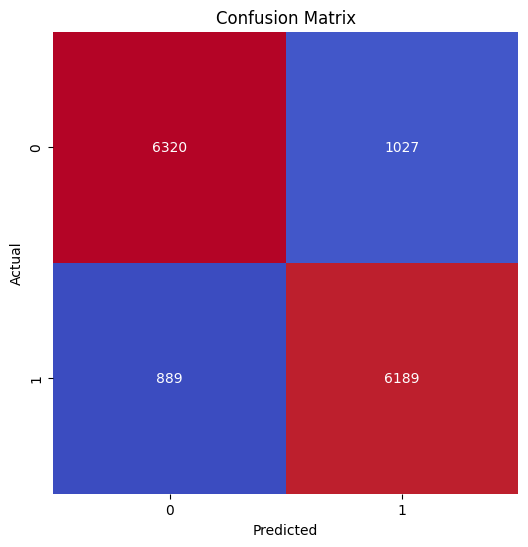



FOR TESTING SET: 
              precision    recall  f1-score   support

           0       0.88      0.86      0.87      7347
           1       0.86      0.87      0.87      7078

    accuracy                           0.87     14425
   macro avg       0.87      0.87      0.87     14425
weighted avg       0.87      0.87      0.87     14425



ROC AUC Score: 94.30%




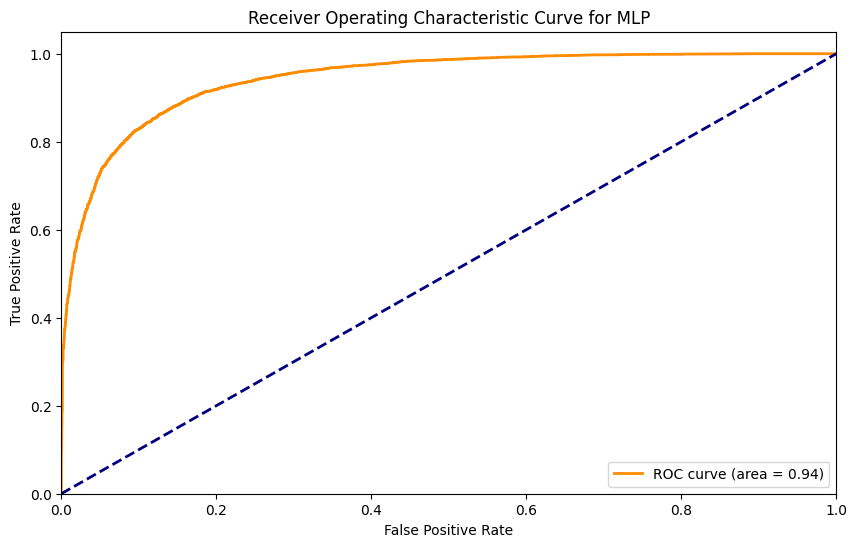

In [100]:
perform_deep_test_analysis(Y_test, test_preds_MLP, test_probs_MLP[:, 1], "MLP")